# Optimization Tutorial

Trey V. Wenger (c) August 2024

Here we demonstrate how to optimize the number of cloud components in a `bayes_spec` model.

In [1]:
# General imports    
import os
import pickle

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

import pymc
print("pymc version:", pymc.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

# Notebook configuration
pd.options.display.max_rows = None
    
# random state
rng = np.random.RandomState(seed=1234)

pymc version: 5.16.2
bayes_spec version: 1.4.3+8.g2908c9c.dirty


## Model Definition and Simulated Data

Like in the basic tutorial for `GaussNoiseModel`, our model is a Gaussian line profile with the spectral noise as a free parameter. We generate synthetic data as in the basic tutorial, and the data key must be `"observation"` for this model.

Text(0, 0.5, 'Brightness Temperature (K)')

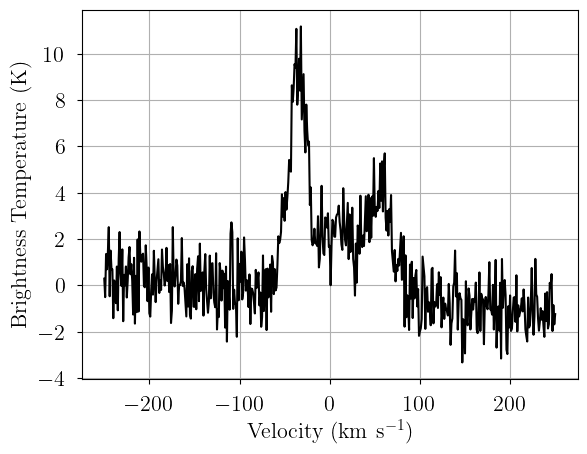

In [2]:
from bayes_spec import SpecData
from bayes_spec.models import GaussNoiseModel

# Generate dummy data format for simulation
velocity_axis = np.linspace(-250.0, 250.0, 501) # km/s
noise = 1.0 # K
brightness_data = noise * np.random.randn(len(velocity_axis)) # K

observation = SpecData(
    velocity_axis,
    brightness_data,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
dummy_data = {"observation": observation}

# Initialize and define the model
model = GaussNoiseModel(dummy_data, n_clouds=3, baseline_degree=2, seed=1234, verbose=True)
model.add_priors(
    prior_line_area = 500.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 25.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 1.0, # width of half-normal distribution prior on spectral rms (K)
)
model.add_likelihood()

# Simulate observation
sim_brightness = model.model.observation.eval({
    "fwhm": [25.0, 40.0, 35.0], # FWHM line width (km/s)
    "line_area": [250.0, 125.0, 175.0], # line area (K km/s)
    "velocity": [-35.0, 10.0, 55.0], # velocity (km/s)
    "observation_baseline_norm": [-0.5, -2.0, 3.0], # normalized baseline coefficients
    "rms_observation": noise, # spectral rms (K)
})

# Plot the simulated data
plt.plot(dummy_data["observation"].spectral, sim_brightness, 'k-')
plt.xlabel(dummy_data["observation"].xlabel)
plt.ylabel(dummy_data["observation"].ylabel)

In [3]:
# Pack simulated data into SpecData
observation = SpecData(
    velocity_axis,
    sim_brightness,
    noise,
    xlabel=r"Velocity (km s$^{-1}$)",
    ylabel="Brightness Temperature (K)",
)
data = {"observation": observation}

## `Optimize`

We use the `Optimize` class for optimization.

In [4]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    GaussNoiseModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=2,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_line_area = 200.0, # mode of k=2 gamma distribution prior on line area (K km s-1)
    prior_fwhm = 30.0, # mode of k=2 gamma distribution prior on FWHM line width (km s-1)
    prior_velocity = [0.0, 50.0], # mean and width of normal distribution prior on centroid velocity (km s-1)
    prior_baseline_coeffs = [1.0, 1.0, 1.0], # width of normal distribution prior on normalized baseline coefficients
    prior_rms = 2.0, # width of half-normal distribution prior on spectral rms (K)
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [5]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [6]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 2.882e+03
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 1,099.5


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.967e+03

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 1,025.9


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.575e+03

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,132


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.538e+03

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,502.3


No solution found!
GMM found 0 unique solutions

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,126.6


No solution found!
GMM found 0 unique solutions

Sampling best model (n_cloud = 3)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,132
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


GMM converged to unique solution


The "best" model is saved in `opt.best_model`.

In [7]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.075,0.523,8.044,9.920,0.019,0.014,776.0,1918.0,1.0
amplitude[1],4.063,0.570,2.918,4.945,0.023,0.016,683.0,1439.0,1.0
amplitude[2],2.855,0.260,2.385,3.351,0.006,0.004,1885.0,2861.0,1.0
fwhm[0],23.424,1.536,20.430,26.143,0.052,0.037,876.0,2006.0,1.0
fwhm[1],31.050,4.560,22.645,39.995,0.172,0.122,708.0,1556.0,1.0
fwhm[2],58.031,21.918,27.933,97.002,1.010,0.715,544.0,1437.0,1.0
fwhm_norm[0],0.781,0.051,0.681,0.871,0.002,0.001,876.0,2006.0,1.0
fwhm_norm[1],1.035,0.152,0.755,1.333,0.006,0.004,708.0,1556.0,1.0
fwhm_norm[2],1.934,0.731,0.931,3.233,0.034,0.024,544.0,1437.0,1.0
line_area[0],226.644,23.161,184.120,264.795,0.968,0.685,613.0,1813.0,1.0


With `approx=False`, the optimization algorithm samples each model with MCMC (or SMC if `smc=True`) and determines which is the first model with a BIC within `bic_threshold` of the minimum across all models. This is more accurate, but slower. Be careful not to set `max_n_clouds` too high!

In [8]:
opt.optimize(sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 2.882e+03
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2300
Interrupted at 2,299 [2%]: Average Loss = 1,099.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.965e+03

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 1,025.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.575e+03

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3800
Interrupted at 3,799 [3%]: Average Loss = 1,132
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = 1.536e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 2100
Interrupted at 2,099 [2%]: Average Loss = 1,502.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 59 seconds.


There were 294 divergences in converged chains.
GMM found 2 unique solutions
Solution 0: chains [0]
Solution 1: chains [1, 2, 3]
Label order mismatch in solution 1
Chain 1 order: [3 1 0 2]
Chain 2 order: [1 2 3 0]
Chain 3 order: [3 1 2 0]
Adopting (first) most common order: [1 2 3 0]
n_cloud = 4 solution = 0 BIC = 1.574e+03
n_cloud = 4 solution = 1 BIC = 1.710e+03

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 4300
Interrupted at 4,299 [4%]: Average Loss = 1,126.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [observation_baseline_norm, line_area_norm, fwhm_norm, velocity_norm, rms_observation_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 164 seconds.


There were 1382 divergences in converged chains.
GMM found 2 unique solutions
Solution 0: chains [1]
Solution 1: chains [2]
n_cloud = 5 solution = 0 BIC = 1.600e+03
n_cloud = 5 solution = 1 BIC = 1.599e+03



Notice that models with more complexity than is present in the data (i.e., `n_clouds` > the true number of clouds) tend to have more divergences and difficulty converging.

In [9]:
print(f"Best model has n_clouds = {opt.best_model.n_clouds}")
az.summary(opt.best_model.trace.solution_0)

Best model has n_clouds = 3


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
amplitude[0],9.075,0.523,8.044,9.920,0.019,0.014,776.0,1918.0,1.0
amplitude[1],4.063,0.570,2.918,4.945,0.023,0.016,683.0,1439.0,1.0
amplitude[2],2.855,0.260,2.385,3.351,0.006,0.004,1885.0,2861.0,1.0
fwhm[0],23.424,1.536,20.430,26.143,0.052,0.037,876.0,2006.0,1.0
fwhm[1],31.050,4.560,22.645,39.995,0.172,0.122,708.0,1556.0,1.0
fwhm[2],58.031,21.918,27.933,97.002,1.010,0.715,544.0,1437.0,1.0
fwhm_norm[0],0.781,0.051,0.681,0.871,0.002,0.001,876.0,2006.0,1.0
fwhm_norm[1],1.035,0.152,0.755,1.333,0.006,0.004,708.0,1556.0,1.0
fwhm_norm[2],1.934,0.731,0.931,3.233,0.034,0.024,544.0,1437.0,1.0
line_area[0],226.644,23.161,184.120,264.795,0.968,0.685,613.0,1813.0,1.0


With posteriors sampled with MCMC, we can also use leave-one-out cross-validation to perform model comparison.

In [10]:
# Populate models with likelihood samples
for model in opt.models.values():
    with model.model:
        pm.compute_log_likelihood(model.trace)

Output()

Output()

Output()

Output()

Output()

In [11]:
# leave-one-out cross validation
loo = az.compare({
    n_gauss: model.trace for n_gauss, model in opt.models.items()
    if model.solutions # ignore models with no valid solutions
})
loo

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
3,0,-724.567714,12.842922,0.000000,0.847091,14.223465,0.000000,False,log
4,1,-725.001082,12.796877,0.433368,0.000000,13.855840,0.769995,False,log
5,2,-725.158967,14.215430,0.591253,0.152909,14.510445,1.311658,False,log
2,3,-756.415658,10.423515,31.847944,0.000000,15.892993,8.777417,False,log
1,4,-962.152856,9.749323,237.585142,0.000000,25.799245,25.291858,False,log


The model with the largest `elpd_loo` is preferred.

Sampling: [observation]


Output()

array([[<Axes: xlabel='Velocity (km s$^{-1}$)', ylabel='Brightness Temperature (K)'>]],
      dtype=object)

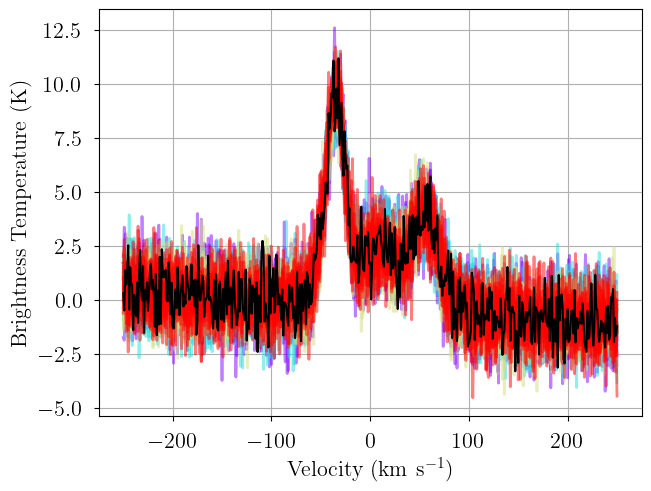

In [12]:
from bayes_spec.plots import plot_predictive

posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
plot_predictive(model.data, posterior.posterior_predictive)